In [1]:

from torch.utils.data import DataLoader
import torch
import ssl
from Solvers import SolverEmbedding,Loss
from scipy.stats import norm
import os
from Models.EncoderModels import TextEncoderWithATTN,TransferLearningALBERT,TextEncoder
from config import cfg
from dataEmbedding.dataEmbedding import Read_Load_BuildBatch
from dataEmbedding.dataEmbeddingLoader import GenerateDataLoader,check_dataset,collate_embedding
from dataEmbedding.generateEmbedding import build_embeedings_CWGAN, singleRun
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree
import pickle
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")

device=cfg.DEVICE
print(device)
torch.manual_seed(cfg.SEED)
np.random.seed(cfg.SEED)
PYTORCH_ENABLE_MPS_FALLBACK=1
#for mac os fix 
ssl._create_default_https_context = ssl._create_unverified_context

cuda


In [2]:
stanData=Read_Load_BuildBatch(cfg.EMBEDDING_BATCH_SIZE)

Median of list is : 14.0
Mean: 16.300818040383426


Text(0.5, 1.0, 'Fit Values: 16.30 and 8.49')

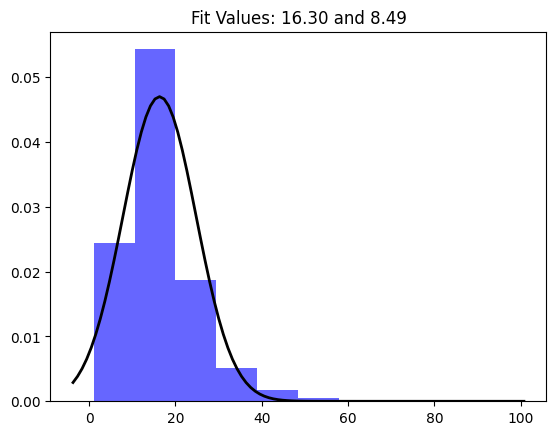

In [3]:
stanData.wordlens.sort()
mid = len(stanData.wordlens) // 2
res = (stanData.wordlens[mid] + stanData.wordlens[~mid]) / 2
print("Median of list is : " + str(res))
print("Mean: "+ str(sum(stanData.wordlens)/len(stanData.wordlens)))

mu, std = norm.fit(stanData.wordlens) 
  
# Plot the histogram.
plt.hist(stanData.wordlens, density=True, alpha=0.6, color='b')
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

In [3]:
criterion={
        #'metric_main': Loss.InstanceMetricLoss(device=cfg.DEVICE),
        'metric_separator': Loss.TripletLoss(device=cfg.DEVICE),
        'metric_main':Loss.NPairLoss(device=cfg.DEVICE),
        #'metric_separator':Loss.customSimilarityLoss()
        }

if cfg.EMBEDDING_ALBERT:
    TextModel=TransferLearningALBERT()
    for i in TextModel.parameters():
        i.requires_grad_=False
else:
    TextModel=TextEncoder(len(stanData.word_to_idx))
TextModel=TextModel.to(device)

optimizer = torch.optim.Adam(TextModel.parameters(), lr=cfg.EMBEDDING_LR, weight_decay=cfg.EMBEDDING_WEIGHT_DC)
history=SolverEmbedding.Solver(TextModel,stanData,optimizer,criterion,cfg.EMBEDDING_BATCH_SIZE,'online',device)

In [4]:
history.train(cfg.EMBEDDING_EPOCH_NR,stanData.idx_to_word)

Epoch [1/160] starting...

Training...


KeyboardInterrupt: 

In [5]:
build_embeedings_CWGAN(os.path.join(cfg.EMBEDDING_TEXT_MODELS_PATH,'text_encoder.pth'),TextEncoder(len(stanData.word_to_idx)),stanData.data_group_train,stanData.word_to_idx,cfg.EMBEDDING_SAVE_PATH,'train')
build_embeedings_CWGAN(os.path.join(cfg.EMBEDDING_TEXT_MODELS_PATH,'text_encoder.pth'),TextEncoder(len(stanData.word_to_idx)),stanData.data_group_test,stanData.word_to_idx,cfg.EMBEDDING_SAVE_PATH,'test')
build_embeedings_CWGAN(os.path.join(cfg.EMBEDDING_TEXT_MODELS_PATH,'text_encoder.pth'),TextEncoder(len(stanData.word_to_idx)),stanData.data_group_val,stanData.word_to_idx,cfg.EMBEDDING_SAVE_PATH,'val')

100%|██████████| 59/59 [00:01<00:00, 38.22it/s]


In [10]:
with open('./../GeneratedEmbeddings/val.p', 'rb') as pickle_file:
    tmp=pickle.load(pickle_file)


#zmienic w generatorze emebdingow jesli sie chce miec do testów

simMat=np.zeros([len(tmp),128])
textList=[]
for i,elem in enumerate(tmp):
    simMat[i]=elem[2].cpu()
    values = [stanData.idx_to_word[str(key)] for key in elem[3].tolist() if key!=0]
    textList.append(' '.join(values))
    
with open('./../GeneratedEmbeddings/test.p', 'rb') as pickle_file:
    tmp=pickle.load(pickle_file)

simMatTest=np.zeros([len(tmp),128])
textListTest=[]
for i,elem in enumerate(tmp):
    simMatTest[i]=elem[2].cpu()
    values = [stanData.idx_to_word[str(key)] for key in elem[3].tolist() if key!=0]
    textListTest.append(' '.join(values))
    

In [14]:
patternIdx=9
similarIndex=cKDTree(simMat).query(simMatTest[patternIdx], k=1)[1]
print(textList[similarIndex])
print(textListTest[patternIdx])

gray colored , wooden center table . four short leg with plain rectangular top .
gray colored , wooden chair . four pole leg with curved square seat and rectangular back .
